In [49]:
# Get the main module:
import daschlab
import pandas as pd

# Set up Bokeh plots:
from bokeh.io import output_notebook
output_notebook()

# Get some other imports that will be useful:
from astropy import units as u
from bokeh.plotting import figure, show
import numpy as np
from daschlab.photometry import AFlags, BFlags# # Get the main module:
import daschlab
import pandas as pd

# Set up Bokeh plots:
from bokeh.io import output_notebook
output_notebook()

# Get some other imports that will be useful:
from astropy import units as u
from bokeh.plotting import figure, show
import numpy as np
from daschlab.photometry import AFlags, BFlags

Loading BokehJS ...

Loading BokehJS ...

In [53]:
import daschlab
import pandas as pd
from daschlab import open_session
from astropy import units as u

# List of targets
sim_targets = ['KIC 8462852']

def save_blue_points_csv(source_name):
    try:
        # Open a DASCH session and select the target
        sess = open_session(source=source_name)
        sess.select_target(name=source_name)
        sess.select_refcat("apass")
        
        # Retrieve the lightcurve (using TARGET_ID=0)
        TARGET_ID = 0
        lc = sess.lightcurve(TARGET_ID)
        lc.apply_standard_rejections()
        lc.reject.sep_above(5 * u.arcsec, tag="sep")
        lc.reject.any_aflags(AFlags.SUSPECTED_DEFECT, tag="aflags")
        # lc.reject.meteor(tag="meteor")
        # lc.reject.not_.narrow(tag="non-narrow")
        lc.plot()
        
        # Drop rejected (masked) points (as done in the plot() method)
        main = lc.drop.rejected(verbose=False)
        
        # Add the synthetic "year" column calculated from the "time" column
        main["year"] = main["time"].jyear
        
        # Split the data into detections and limits (non-detections)
        main_detect, main_limit = main.split_by.detected()
        
        # main_detect contains the detections that are plotted in blue
        df_blue = main_detect.to_pandas()
        
        # Save the DataFrame with the blue detections (including time and year)
        # Sanitize filename
        import re
        safe_name = re.sub(r'[^A-Za-z0-9]+', '_', source_name)
        # csv_filename = f"{source_name.replace(' ', '_')}_blue_detections.csv"
        csv_filename = f"{safe_name}_blue_detections.csv"
        
        df_blue.to_csv(csv_filename, index=False)
        print(f"Blue (unmasked) lightcurve points for {source_name} saved to {csv_filename}")

        p = lc.plot()
    
    except Exception as e:
        print(f"Error processing {source_name}: {e}")

# Process each target
for source in sim_targets:
    save_blue_points_csv(source)

from erfa import ErfaWarning

 [astropy.utils.exceptions]


Opened DASCH session at disk location `daschlab_kic_8462852`
- Query target: `KIC 8462852`
- Refcat: 2289 sources from `apass`
- Exposures: 19227 relevant exposures


Rejecting standard AFLAGS ...
Assigned rejection tag `aflags` to bit number 1
Marked 805 new rows as rejected; 805 total are rejected

After rejections, 1912 non-rejected detections remain.
Assigned rejection tag `sep` to bit number 2
Marked 255 new rows as rejected; 1060 total are rejected
Marked 49 new rows as rejected; 1109 total are rejected


Blue (unmasked) lightcurve points for KIC 8462852 saved to KIC_8462852_blue_detections.csv



--- Analysis summary (filtered data, NO exclusions) ---
Total after quality filter: 1608

OLS on all points:
  Slope = 0.001449 ± 0.000127 mag/yr  (0.145 ± 0.013 mag/century)
  Baseline = 100.05 yr
  Δm (OLS, min→max) = 0.145 ± 0.013 mag

RLM (Tukey biweight) — robust fit (keeps all points, downweights outliers):
  Slope = 0.001646 ± 0.000114 mag/yr
  Equivalent: 0.165 ± 0.011 mag/century
  Δm (RLM) = 0.165 ± 0.011 mag

Bootstrap (RLM) — empirical ~68% CI from resampling:
  Slope median = 0.001652 mag/yr
  Slope 1σ CI ≈ [0.001538, 0.001764] mag/yr
  Δm median = 0.165 mag; Δm 1σ CI ≈ [0.154, 0.176] mag

Contamination-sensitivity bootstrap (simulating up to 10% bad points):
  Slope median under contamination = 0.001599 mag/yr
  Slope 95% CI under contamination ≈ [0.001348, 0.001868] mag/yr
  Δm median under contamination = 0.160 mag
  Δm 95% CI under contamination ≈ [0.135, 0.187] mag

Residuals & variability (w.r.t RLM trend):
  RMS (resid w.r.t RLM) = 0.1265 mag
  Variance (resid w.r.

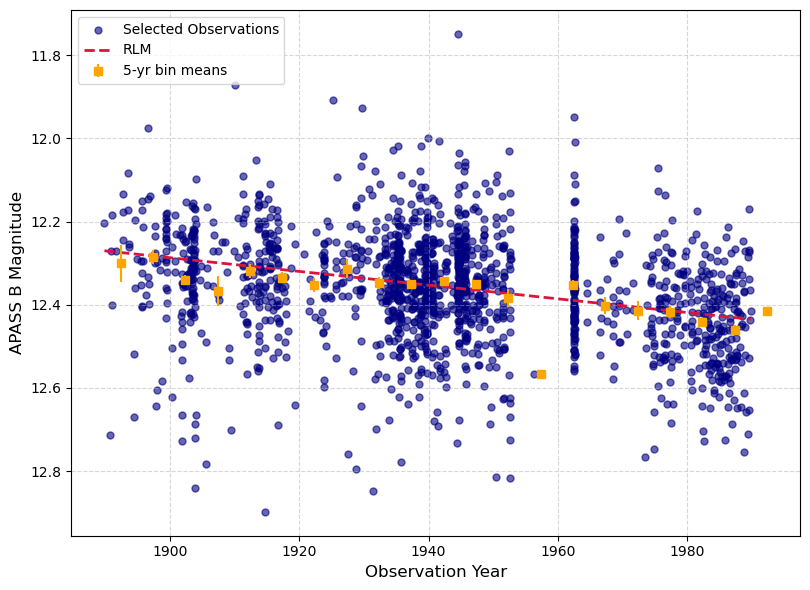

Saved final CSV with fits/residuals to: KIC_8462852_blue_detections_robust_with_fits.csv


In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.robust.norms import TukeyBiweight
from statsmodels.robust.robust_linear_model import RLM
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Load and filter data (exactly as requested)
# -------------------------------
csv_filename = "KIC_8462852_blue_detections.csv"
df = pd.read_csv(csv_filename)
df = df.dropna(subset=["year", "magcal_magdep", "limiting_mag_local"]).copy()

# Keep robust detections: at least 0.3 mag brighter than local limit
mask_detect = df["magcal_magdep"] <= (df["limiting_mag_local"] - 0.3)
df_filt = df.loc[mask_detect].copy()

if len(df_filt) < 2:
    raise ValueError("Not enough points after quality filter to fit.")

# Extract data arrays
x = df_filt["year"].values.astype(float)
y = df_filt["magcal_magdep"].values.astype(float)
N = len(x)

# Baseline for delta calculation
x_min, x_max = x.min(), x.max()
x_span = x_max - x_min

# -------------------------------
# 1) OLS on ALL filtered points (no exclusions)
# -------------------------------
X_ols = sm.add_constant(x)
ols_res = sm.OLS(y, X_ols).fit(cov_type="HC3")  # heteroskedastic-robust SEs

m_ols = float(ols_res.params[1])
b_ols = float(ols_res.params[0])
m_ols_se = float(ols_res.bse[1])
b_ols_se = float(ols_res.bse[0])

delta_ols = m_ols * x_span
delta_ols_se = m_ols_se * x_span

# -------------------------------
# 2) Robust fit (RLM with Tukey biweight) — downweights but DOES NOT DELETE points
# -------------------------------
X_rlm = sm.add_constant(x)
rlm_model = RLM(y, X_rlm, M=TukeyBiweight())
rlm_res = rlm_model.fit(maxiter=50, tol=1e-6)

m_rlm = float(rlm_res.params[1])
b_rlm = float(rlm_res.params[0])
# covariance matrix from RLM results — fallback if not available
try:
    cov_rlm = rlm_res.cov_params()
    m_rlm_se = float(np.sqrt(cov_rlm[1, 1]))
    b_rlm_se = float(np.sqrt(cov_rlm[0, 0]))
except Exception:
    # fallback to bootstrapping below
    cov_rlm = None
    m_rlm_se = np.nan
    b_rlm_se = np.nan

delta_rlm = m_rlm * x_span
delta_rlm_se = (m_rlm_se * x_span) if not np.isnan(m_rlm_se) else np.nan

# -------------------------------
# 3) Bootstrap CI for robust estimator (resampling with replacement)
#    This gives empirical CIs that reflect sampling and naturally sample contaminated points.
# -------------------------------
def fit_rlm_on_arrays(xarr, yarr):
    Xtmp = sm.add_constant(xarr)
    res = RLM(yarr, Xtmp, M=TukeyBiweight()).fit(maxiter=50)
    return float(res.params[1]), float(res.params[0])

n_boot = 1000  # increase if you want smoother percentiles; 1000 is typical
rng = np.random.default_rng(42)
slopes_boot = np.empty(n_boot)
intercepts_boot = np.empty(n_boot)

for i in range(n_boot):
    idx = rng.integers(0, N, N)  # bootstrap indices
    xs = x[idx]; ys = y[idx]
    try:
        ms, bs = fit_rlm_on_arrays(xs, ys)
    except Exception:
        ms, bs = np.nan, np.nan
    slopes_boot[i] = ms
    intercepts_boot[i] = bs

# drop NaNs if any
valid = np.isfinite(slopes_boot)
slopes_boot = slopes_boot[valid]
intercepts_boot = intercepts_boot[valid]

slope_rlm_boot_median = np.median(slopes_boot)
slope_rlm_boot_ci = np.percentile(slopes_boot, [16, 84])  # ~1-sigma equiv
delta_rlm_boot = slope_rlm_boot_median * x_span
delta_rlm_boot_ci = (slope_rlm_boot_ci * x_span)

# -------------------------------
# 4) Contamination-sensitivity bootstrap:
#    In each replicate, after resampling, randomly replace 10% of the points with large-noise draws.
#    This simulates the worst-case effect of 10% "wrong" measurements.
# -------------------------------
slopes_cont = np.empty(n_boot)
intercepts_cont = np.empty(n_boot)
contam_frac = 0.10  # 10% possibly wrong

y_median = np.median(y)
y_std = np.std(y, ddof=1)
contam_sigma = 3.0 * y_std  # heavy noise scale (tunable)

for i in range(n_boot):
    idx = rng.integers(0, N, N)
    xs = x[idx].copy()
    ys = y[idx].copy()
    # choose 10% positions in this bootstrap sample to contaminate
    k = max(1, int(np.floor(contam_frac * N)))
    contam_idx = rng.choice(N, k, replace=False)
    ys[contam_idx] = rng.normal(loc=y_median, scale=contam_sigma, size=k)
    try:
        ms, bs = fit_rlm_on_arrays(xs, ys)
    except Exception:
        ms, bs = np.nan, np.nan
    slopes_cont[i] = ms
    intercepts_cont[i] = bs

validc = np.isfinite(slopes_cont)
slopes_cont = slopes_cont[validc]

slope_cont_median = np.median(slopes_cont)
slope_cont_ci = np.percentile(slopes_cont, [2.5, 97.5])  # 95% CI under contamination
delta_cont_median = slope_cont_median * x_span
delta_cont_ci = slope_cont_ci * x_span

# -------------------------------
# 5) Detrended variance / RMS (flattened by robust trend)
#    Use residuals relative to RLM trend (keeps all points)
# -------------------------------
resid_rlm_all = y - (m_rlm * x + b_rlm)
rms_resid_rlm = np.sqrt(np.mean(resid_rlm_all**2))
var_resid_rlm = np.var(resid_rlm_all)

# -------------------------------
# 6) Boxcar binning (fixed 5-year bins)
# -------------------------------
bin_size = 5.0
bins = np.arange(x_min, x_max + bin_size, bin_size)
bin_centers = []
bin_means = []
bin_errs = []
for i in range(len(bins) - 1):
    mask_bin = (x >= bins[i]) & (x < bins[i + 1])
    if np.any(mask_bin):
        bin_centers.append((bins[i] + bins[i + 1]) / 2.0)
        bin_means.append(np.mean(y[mask_bin]))
        # stderr if multiple points, nan if single point (we will not print per-bin)
        cnt = np.sum(mask_bin)
        bin_errs.append(np.std(y[mask_bin], ddof=1) / np.sqrt(cnt) if cnt > 1 else np.nan)
bin_centers = np.array(bin_centers)
bin_means = np.array(bin_means)
bin_errs = np.array(bin_errs)

# -------------------------------
# 7) Print concise analysis summary (what you asked for)
# -------------------------------
print("\n--- Analysis summary (filtered data, NO exclusions) ---")
print(f"Total after quality filter: {N}")

print("\nOLS on all points:")
print(f"  Slope = {m_ols:.6f} ± {m_ols_se:.6f} mag/yr  ({100*m_ols:.3f} ± {100*m_ols_se:.3f} mag/century)")
print(f"  Baseline = {x_span:.2f} yr")
print(f"  Δm (OLS, min→max) = {delta_ols:.3f} ± {delta_ols_se:.3f} mag")

print("\nRLM (Tukey biweight) — robust fit (keeps all points, downweights outliers):")
print(f"  Slope = {m_rlm:.6f} {'± ' + f'{m_rlm_se:.6f}' if not np.isnan(m_rlm_se) else '(cov unavailable)'} mag/yr")
if not np.isnan(m_rlm_se):
    print(f"  Equivalent: {100*m_rlm:.3f} ± {100*m_rlm_se:.3f} mag/century")
print(f"  Δm (RLM) = {delta_rlm:.3f} {'± ' + f'{delta_rlm_se:.3f}' if not np.isnan(delta_rlm_se) else ''} mag")

print("\nBootstrap (RLM) — empirical ~68% CI from resampling:")
print(f"  Slope median = {slope_rlm_boot_median:.6f} mag/yr")
print(f"  Slope 1σ CI ≈ [{slope_rlm_boot_ci[0]:.6f}, {slope_rlm_boot_ci[1]:.6f}] mag/yr")
print(f"  Δm median = {delta_rlm_boot:.3f} mag; Δm 1σ CI ≈ [{delta_rlm_boot_ci[0]:.3f}, {delta_rlm_boot_ci[1]:.3f}] mag")

print("\nContamination-sensitivity bootstrap (simulating up to 10% bad points):")
print(f"  Slope median under contamination = {slope_cont_median:.6f} mag/yr")
print(f"  Slope 95% CI under contamination ≈ [{slope_cont_ci[0]:.6f}, {slope_cont_ci[1]:.6f}] mag/yr")
print(f"  Δm median under contamination = {delta_cont_median:.3f} mag")
print(f"  Δm 95% CI under contamination ≈ [{delta_cont_ci[0]:.3f}, {delta_cont_ci[1]:.3f}] mag")

print("\nResiduals & variability (w.r.t RLM trend):")
print(f"  RMS (resid w.r.t RLM) = {rms_resid_rlm:.4f} mag")
print(f"  Variance (resid w.r.t RLM) = {var_resid_rlm:.6f} mag^2")

# compare trend magnitude to RMS
abs_delta = abs(delta_rlm)
if abs_delta > rms_resid_rlm:
    print("\nConclusion: |Δm| (RLM trend magnitude) > RMS variability — trend is larger than typical variability.")
else:
    print("\nConclusion: RMS variability >= |Δm| — variability dominates over long-term trend.")

# -------------------------------
# 8) Plot (no overlapping text on data; legend outside)
# -------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=25, alpha=0.6, color="navy", label="Selected Observations")
# OLS line
x_fit = np.linspace(x_min, x_max, 400)
# plt.plot(x_fit, m_ols * x_fit + b_ols, color="green", linestyle=":", linewidth=1.6, label="OLS (all)")
# RLM line
plt.plot(x_fit, m_rlm * x_fit + b_rlm, color="crimson", linestyle="--", linewidth=2.0, label="RLM")
# Bin means
if len(bin_centers) > 0:
    plt.errorbar(bin_centers, bin_means, yerr=bin_errs, fmt="s", color="orange",
                 markersize=6, label=f"5-yr bin means")

plt.gca().invert_yaxis()
plt.xlabel("Observation Year", fontsize=12)
plt.ylabel("APASS B Magnitude", fontsize=12)
# plt.title(os.path.splitext(os.path.basename(csv_filename))[0], fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(fontsize=10, loc="upper left")
plt.tight_layout(rect=[0, 0, 0.82, 1.0])

# Save plot (kept, as in your earlier code). Remove these two lines if you don't want saving.
out_png = os.path.splitext(csv_filename)[0] + "_robust_analysis.png"
plt.savefig(out_png, dpi=300)
print(f"\nSaved figure to: {out_png}")

plt.show()

# -------------------------------
# 9) Save final CSV with fits + residuals (you asked to save final CSV)
# -------------------------------
df_filt["fit_ols"] = m_ols * df_filt["year"] + b_ols
df_filt["fit_rlm"] = m_rlm * df_filt["year"] + b_rlm
df_filt["resid_ols"] = df_filt["magcal_magdep"] - df_filt["fit_ols"]
df_filt["resid_rlm"] = df_filt["magcal_magdep"] - df_filt["fit_rlm"]

out_csv = os.path.splitext(csv_filename)[0] + "_robust_with_fits.csv"
df_filt.to_csv(out_csv, index=False)
print(f"Saved final CSV with fits/residuals to: {out_csv}")

In [61]:
# Fill in the SIMBAD-resolvable name of your target source:
SOURCE = "KIC 8462852"

# Leave this unchanged unless you're sure that you want something else:
REFCAT = "apass"

In [63]:
sess = daschlab.open_session(source=SOURCE)
sess.select_target(name=SOURCE)
sess.select_refcat(REFCAT)

In [66]:
imaged_exposures = sess.exposures().keep_only.has_imaging()

Dropped 5255 rows; 13972 remaining


In [69]:
from astropy.table import Table

# Get the exposures table
filtered_df = sess.exposures().keep_only.has_imaging()

Dropped 5255 rows; 13972 remaining


In [72]:
filtered_df.candidate_nice_cutouts()

limiting_mag_local,exp_local_id,series,platenum,fwhm_world,ellipticity,background
mag,,,,deg,,
float32,int32,str3,uint32,float32,float32,float32
17.0618953704834,10753,mc,29681,0.006010000128298998,0.081,4236.584
17.057619094848633,17732,mc,36926,0.005427999887615442,0.142,3577.429
17.05738639831543,1944,a,8089,0.0045449999161064625,0.188,4353.394
17.019512176513672,11081,mc,30210,0.006064999848604202,0.07,3879.364
16.96526336669922,4403,mc,11048,0.0037060000468045473,0.013,3434.762
16.879085540771484,9701,rh,6808,0.009688000194728374,0.141,5007.083
16.834035873413086,4226,mc,9800,0.0035830000415444374,0.035,3386.144
16.788368225097656,7667,mc,23570,0.004155999980866909,0.02,4072.128


In [75]:
from astropy.io import fits

imaged_exposures = sess.exposures()
i = 10753
exp = imaged_exposures[i]

relpath = sess.cutout(exp)
assert relpath, f"could not get cutout of {exp.exp_id()}"

- Querying API ...
- Fetched 1399680 bytes in 13 seconds
- Saved `daschlab_kic_8462852\cutouts\10753_mc29681m0s0.fits`


In [78]:
from astropy.io import fits

filepath = r"D:\TLS\Downloads\post-AGB\daschlab_kic_8462852\cutouts\10753_mc29681m0s0.fits"

with fits.open(filepath) as hdul:
    hdul.info()
    # Check data in the primary HDU
    print(hdul[0].header)

Filename: D:\TLS\Downloads\post-AGB\daschlab_kic_8462852\cutouts\10753_mc29681m0s0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (835, 835)   int16   
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                  835 / length of data axis 1                          NAXIS2  =                  835 / length of data axis 2                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H BLANK   =                    0                                                  CTYPE1  = 'RA---TAN'                                              

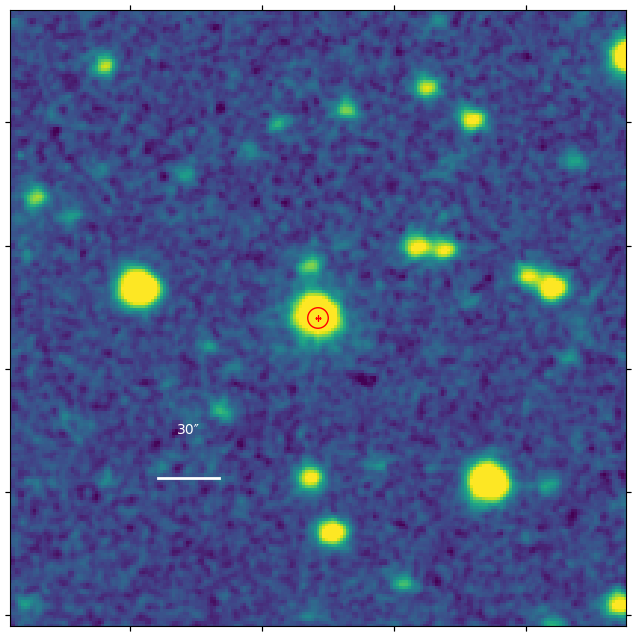

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
import matplotlib.patches as patches
from astropy import units as u

# ---------------- FITS file ----------------
fits_file = filepath  # replace with your FITS file path
with fits.open(fits_file) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header
    wcs = WCS(header)

# ---------------- Extract target info ----------------
ra_deg = header.get("CRVAL1")   # central RA
dec_deg = header.get("CRVAL2")  # central Dec
sky_coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit='deg', frame='icrs')
pixel_coord = wcs.world_to_pixel(sky_coord)

# ---------------- Pixel scale (arcsec/pixel) ----------------
# Use CD matrix if present, else fallback to CDELT
if hasattr(wcs.wcs, 'cd') and wcs.wcs.cd is not None:
    # Approximate scale from CD matrix (diagonal terms)
    pix_scale = np.mean([abs(wcs.wcs.cd[0,0]), abs(wcs.wcs.cd[1,1])]) * 3600
else:
    pix_scale = np.mean([abs(wcs.wcs.cdelt[0]), abs(wcs.wcs.cdelt[1])]) * 3600

# ---------------- User choice: FOV ----------------
fov_arcmin = 5.0   # <-- set manually to 2.0, 5.0, etc.
fov_pixels = (fov_arcmin * 60.0) / pix_scale

# ---------------- Circle radius (aperture) ----------------
radius_arcsec = 5.0
radius_pixels = radius_arcsec / pix_scale

# ---------------- Plot ----------------
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': wcs})

# # Stretch for faint features
# norm = simple_norm(image_data, 'log', percent=99.5)
# im = ax.imshow(image_data, cmap='viridis', origin='lower', norm=norm)

# Better clipping so background doesn't get exaggerated
vmin, vmax = np.nanpercentile(image_data, [.1, 99.1])   # clip low/high outliers
im = ax.imshow(image_data, cmap='viridis', origin='lower',
               vmin=vmin, vmax=vmax, interpolation='nearest')

# Target marker
ax.plot(pixel_coord[0], pixel_coord[1], 'r+', markersize=5)
circle = patches.Circle((pixel_coord[0], pixel_coord[1]),
                        radius_pixels, edgecolor='red',
                        facecolor='none', lw=1.)
ax.add_patch(circle)

# Adjust FOV (zoom)
x0, y0 = pixel_coord
ax.set_xlim(x0 - fov_pixels/2, x0 + fov_pixels/2)
ax.set_ylim(y0 - fov_pixels/2, y0 + fov_pixels/2)

# Scale bar (30 arcsec)
scale_length = 30 * u.arcsec
scale_pix = scale_length.value / pix_scale
sx, sy = x0 - fov_pixels/2 + 50, y0 - fov_pixels/2 + 50
ax.plot([sx, sx + scale_pix], [sy, sy], color='white', lw=2)
ax.text(sx + scale_pix/2, sy + 15, '30″', color='white',
        fontsize=10, ha='center')

# Labels & title
# ax.set_xlabel('RA (J2000)')
# ax.set_ylabel('Dec (J2000)')
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_frame_on(False)
ax.set_title(f"{SOURCE}", fontsize=14)
ax.coords[0].set_axislabel('')
ax.coords[1].set_axislabel('')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)

# plt.tight_layout()
plt.show()

One single good exposure of KIC 8462852 from 30th August 1938.